In [1]:
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import os
import cv2

In [2]:
def get_files(data_path, folder):
    names = []
    folder_path = os.path.join(data_path, folder)
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        for file in os.listdir(subfolder_path):
            if file.endswith(".nrrd") and not file.endswith(".seg.nrrd"):
                names.append(os.path.join(subfolder_path, file))
    return names

Data_path = r"/kaggle/input/mri-data/Data"

Dongyang_data_names = get_files(Data_path, "Dongyang")
KiTS_data_names = get_files(Data_path, "KiTS")
Rider_data_names = get_files(Data_path, "Rider")

In [ ]:
def get_image(name):
    image = sitk.ReadImage(name)
    image = sitk.GetArrayFromImage(image).T
    if image.shape[1] == 666:  #Normalize shape of data y -> 512
        image = image[:, 77:589, :]
    if "Dongyang" in name: #Normalization of background - to see more, look into data_overview.ipynb
        image = image + 1024
    else:
        image[image < 0] = 0
    return image

def resize_image(image):
    image = image.astype(np.float32)
    new_image = []
    for i in range(image.shape[2]):
        image_slice = image[:, :, i]
        new_image.append(cv2.resize(image_slice, (224, 224)))
    return np.stack(new_image, axis=-1)

def normalize_slices(image): #Normalization per slice
    for i in range(image.shape[2]):
        image_slice = image[:, :, i]
        min_val = image_slice.min()
        max_val = image_slice.max()
        if max_val > min_val: #Min_val is 0, to avoid diving by 0 we check if max_val is greater than min_Val
            image[:, :, i] = (image_slice - min_val) / (max_val - min_val)
        else: 
            image[:, :, i] = 0
    return image

def get_voxels(data_names, normalized=False):
    voxels = []
    for name in data_names:
        image = resize_image(get_image(name)) #Resizing before normalization to save memory
        image = normalize_slices(image) if normalized else image 
        voxels.append(image.flatten())
    result = np.concatenate(voxels)
    return result

In [4]:
Dongyang_voxels = get_voxels(Dongyang_data_names, False)
KiTS_voxels = get_voxels(KiTS_data_names, False)
Rider_voxels = get_voxels(Rider_data_names, False)

Dongyang_voxels_normalized = get_voxels(Dongyang_data_names, True) 
KiTS_voxels_normalized = get_voxels(KiTS_data_names, True)
Rider_voxels_normalized = get_voxels(Rider_data_names, True)

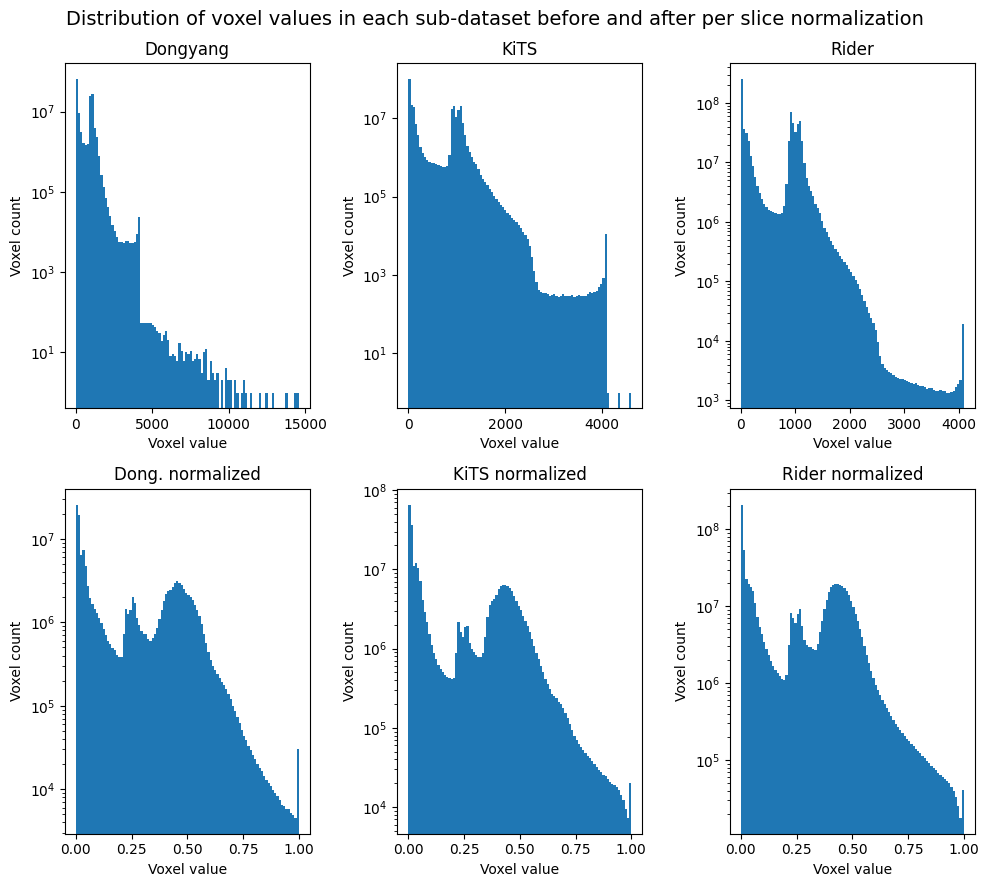

In [15]:
plt.figure(figsize=(10, 9))
plt.suptitle("Distribution of voxel values in each sub-dataset before and after per slice normalization", fontsize=14)

plt.subplot(2, 3, 1)
plt.hist(Dongyang_voxels, bins=100)
plt.yscale('log')
plt.title("Dongyang")
plt.xlabel("Voxel value")
plt.ylabel("Voxel count")

plt.subplot(2, 3, 2)
plt.hist(KiTS_voxels, bins=100)
plt.yscale('log')
plt.title("KiTS")
plt.xlabel("Voxel value")
plt.ylabel("Voxel count")

plt.subplot(2, 3, 3)
plt.hist(Rider_voxels, bins=100)
plt.yscale('log')
plt.title("Rider")
plt.xlabel("Voxel value")
plt.ylabel("Voxel count")

plt.subplot (2, 3, 4)
plt.hist(Dongyang_voxels_normalized, bins=100)
plt.yscale('log')
plt.title("Dong. normalized")
plt.xlabel("Voxel value")
plt.ylabel("Voxel count")

plt.subplot(2, 3, 5)
plt.hist(KiTS_voxels_normalized, bins=100)
plt.yscale('log')
plt.title("KiTS normalized")
plt.xlabel("Voxel value")
plt.ylabel("Voxel count")

plt.subplot(2, 3, 6)
plt.hist(Rider_voxels_normalized, bins=100)
plt.yscale('log')
plt.title("Rider normalized")
plt.xlabel("Voxel value")
plt.ylabel("Voxel count")

plt.tight_layout()
plt.show()